In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.layers import *
#from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/envs/provas/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/provas/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/provas/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/provas/lib/python3.6/site-packages/tensorflow/pyth

In [2]:
data_dir = "/home/loliveros/Vision/Dataset_Analisis_Docs/data_road"
seg_dir = data_dir + "/training/mask"
img_dir = data_dir + "/training/image_2"
seg_files = np.array(os.listdir(seg_dir))
#check the first file
first_file = seg_files[0]
print(first_file)

template_batch6_thread3_37.jpg


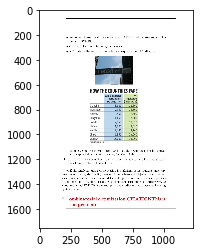

In [3]:
#see the first img
seg = load_img(seg_dir + "/" + first_file)
img = load_img(img_dir + "/" + first_file)
plt.imshow(img)

In [4]:
#see the shape of img
print("img_shape = ", img_to_array(img).shape)

#see the number of classes
n_classes = int(np.max(seg)+1)
print("There are {} labels".format(n_classes))

img_shape =  (1753, 1240, 3)
There are 7 labels


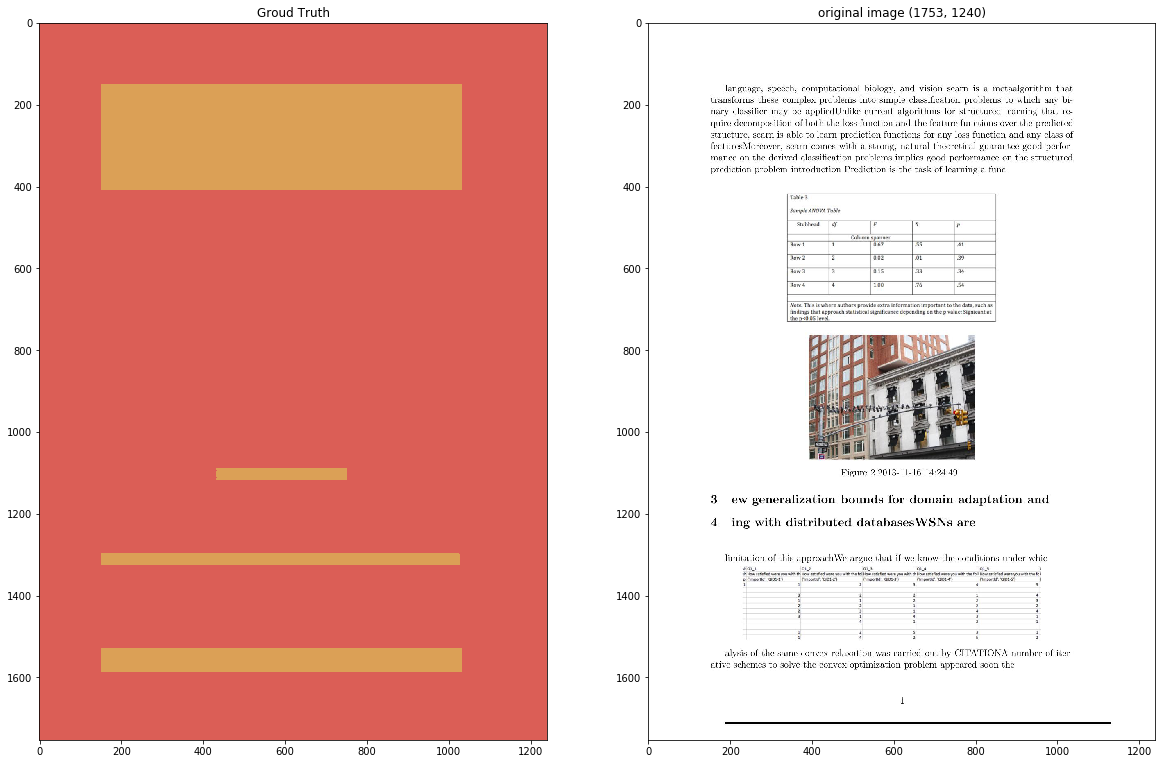

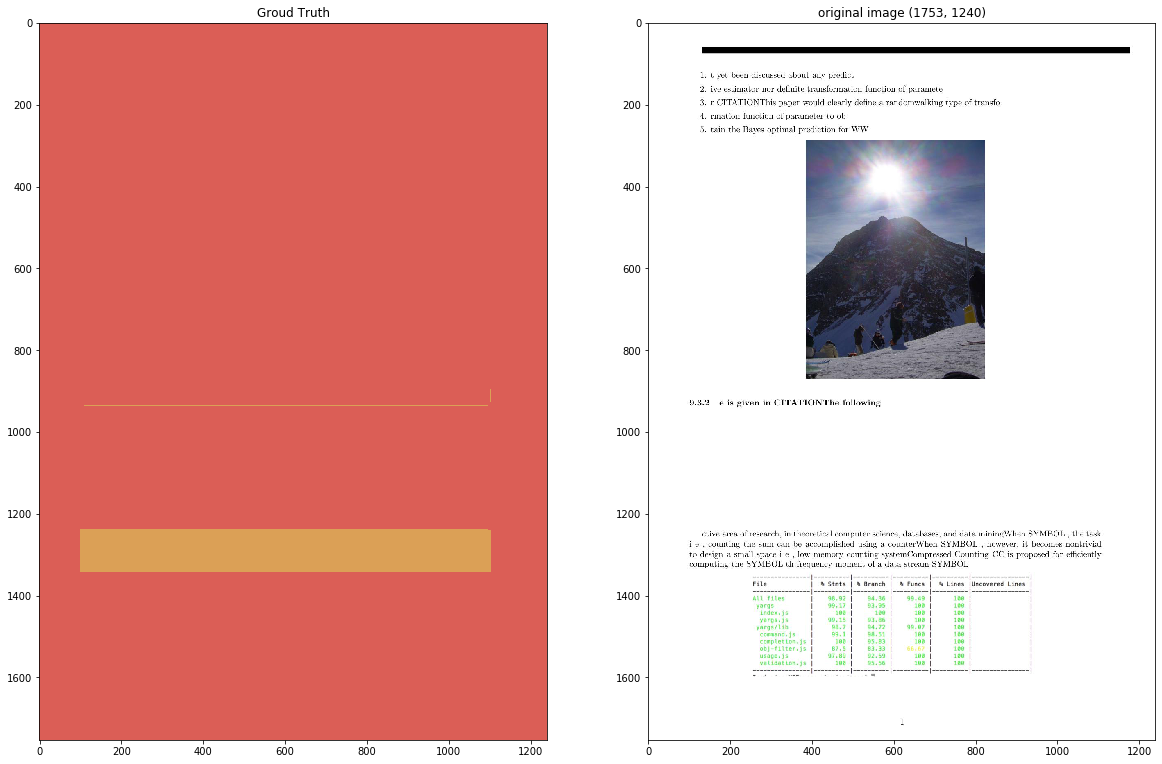

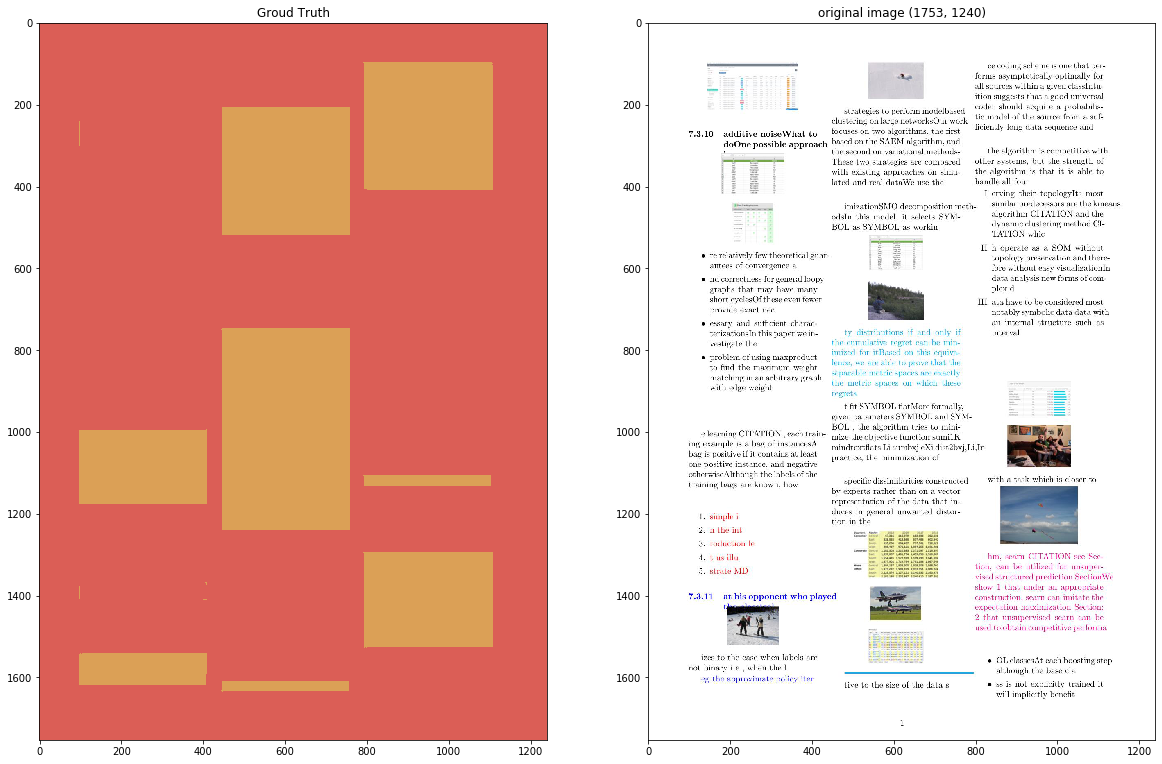

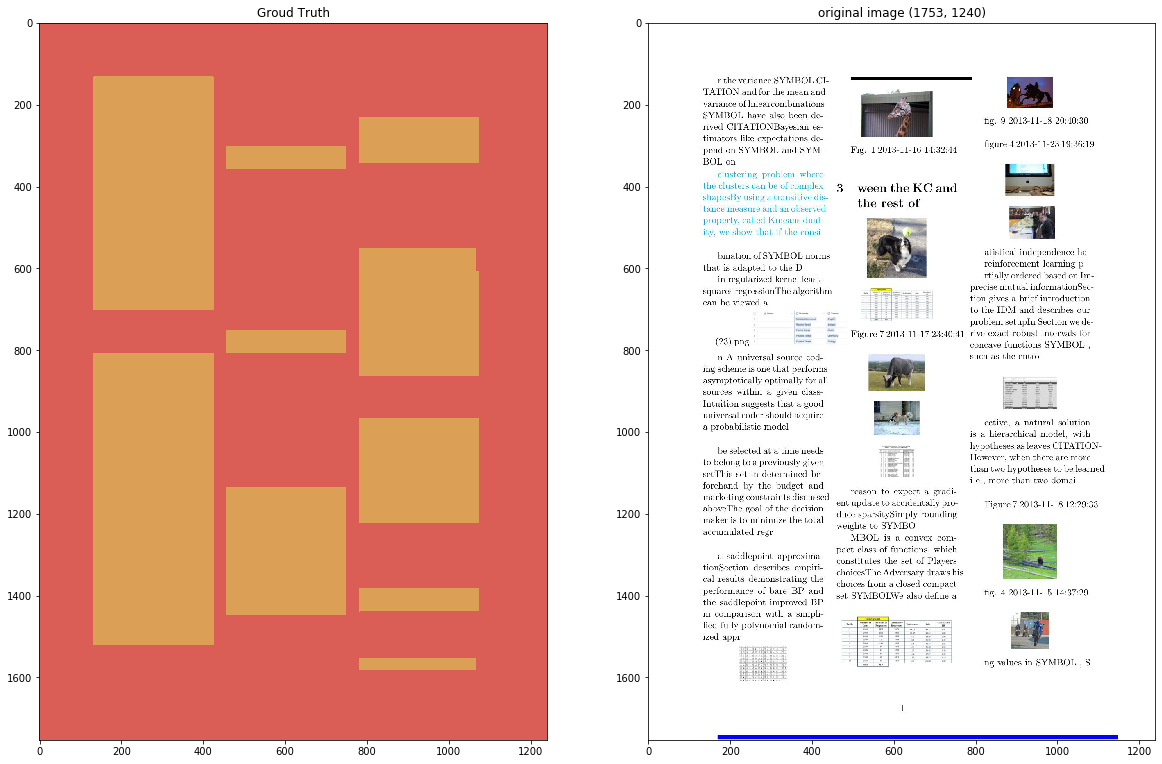

In [5]:
#show the ground_truth 
def design_colormap(seg, n_classes):
    """
    seg: (width, height)
    return: (width, height,3)
    """
    seg_img = np.zeros(seg.shape+(3,)).astype("float")
    colors = sns.color_palette("hls", 12)
    
    for label in np.arange(n_classes):
        segc = (seg == label)
        segc = segc.astype("int")
        for channel in range(3):
            seg_img[:, :, channel] += segc*(colors[label][channel])
    return seg_img

for fnm in seg_files[np.random.choice(len(seg_files),4,replace=False)]:
    seg = load_img(seg_dir + "/" + fnm) # (360, 480, 3)
    seg = img_to_array(seg)
    seg_img = design_colormap(seg[:,:,0],n_classes)
    img = load_img(img_dir + "/" + fnm)
    img = img_to_array(img)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,2,1)
    ax.imshow(seg_img)
    ax.set_title("Groud Truth")
    
    ax = fig.add_subplot(1,2,2)
    ax.imshow(img/255.0)
    ax.set_title("original image {}".format(img.shape[:2]))

In [6]:
import cv2
#resize images to (224,224) for VGG
input_height , input_width = 224 , 224
output_height , output_width = 224 , 224

def getSegmentationArr(path, n_classes,width, height):
    seg_labels = np.zeros((height, width, n_classes))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height))
    img = img[:, : , 0]

    for c in range(n_classes):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels

images = np.array(os.listdir(img_dir))
images.sort()
segmentations  = os.listdir(seg_dir)
segmentations.sort()
    
X = []
Y = []
for im, seg in zip(images,segmentations):
    img = cv2.imread(img_dir + '/'+  im, 1)
    img = cv2.resize(img, (input_width , input_height ))
    img = img_to_array(img)
    X.append(img)
    Y.append(getSegmentationArr( seg_dir + '/'+ seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
X = X/255.0
print(X.shape,Y.shape)

(3256, 224, 224, 3) (3256, 224, 224, 7)


In [7]:

VGG_Weights_path = "/home/loliveros/Vision/Dataset_Analisis_Docs/vgg/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
#VGG微调
def FCN8(IMG_input, nClasses,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller   
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(IMG_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)## (None, 7, 7, 512)
     
    vgg  = Model(img_input, pool5)
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    o = (Conv2D(n_classes, (7, 7), activation='relu', padding='same', name="conv6"))(pool5)
        
    ## 4 times upsamping for final layer
    conv6_4 = Conv2DTranspose(n_classes, kernel_size=(4,4),  strides=(4,4), use_bias = False)(o)
    ## 2 times upsampling for pool411
    pool4_n = ( Conv2D(n_classes, (1, 1), activation='relu', padding='same', name="pool4_n"))(pool4)
    pool4_n_2 = (Conv2DTranspose(nClasses, kernel_size=(2,2), strides=(2,2), use_bias=False))(pool4_n)
    #1 time for pool3
    pool3_n = (Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_n"))(pool3)
        
    o = Add(name="add")([pool4_n_2, pool3_n, conv6_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False)(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)
    return model

img_input = Input(shape=(input_height,input_width, 3)) 
model = FCN8(img_input,n_classes,  
             input_height = 224, 
             input_width = 224)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_c

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_var, y_train, y_var = train_test_split(X,Y, test_size=0.20)
print(X_train.shape, y_train.shape)
print(X_var.shape, y_var.shape)

(2604, 224, 224, 3) (2604, 224, 224, 7)
(652, 224, 224, 3) (652, 224, 224, 7)


In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])
batch_size = 2
epochs = 30
show = X_train.shape[0]//batch_size
history = model.fit(X_train,y_train,
                  validation_data=(X_var,y_var),
                  epochs=epochs,verbose=2,batch_size = batch_size
                  )

Train on 2604 samples, validate on 652 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
2604/2604 - 182s - loss: 0.6457 - acc: 0.7701 - val_loss: 0.4482 - val_acc: 0.8401
Epoch 2/30
2604/2604 - 175s - loss: 0.4556 - acc: 0.8446 - val_loss: 0.3918 - val_acc: 0.8644
Epoch 3/30
2604/2604 - 175s - loss: 0.3584 - acc: 0.8852 - val_loss: 0.3212 - val_acc: 0.8974
Epoch 4/30
2604/2604 - 175s - loss: 0.2929 - acc: 0.9061 - val_loss: 0.2899 - val_acc: 0.9123
Epoch 5/30
2604/2604 - 175s - loss: 0.2641 - acc: 0.9160 - val_loss: 0.2544 - val_acc: 0.9198
Epoch 6/30
2604/2604 - 175s - loss: 0.2484 - acc: 0.9207 - val_loss: 0.2579 - val_acc: 0.9166
Epoch 7/30
2604/2604 - 175s - loss: 0.2351 - acc: 0.9246 - val_loss: 0.2352 - val_acc: 0.9262
Epoch 8/30
2604/2604 - 175s - loss: 0.2287 - acc: 0.9266 - val_loss: 0.2293 - val_acc: 0.9273
Epoch 9/30
2604/2604 - 175s - loss: 0.2163 - acc: 0.9303 - val_loss: 0.2174 - val_acc: 0.9310
Epoch 10/30
2

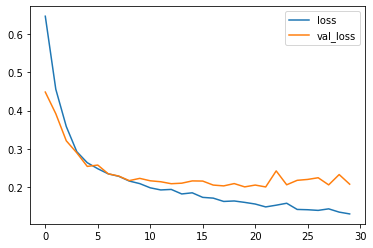

In [10]:
for key in ['loss', 'val_loss']:
    plt.plot(history.history[key],label=key)
plt.legend()
plt.show()

In [11]:
#Visualize the model performance
y_vari = np.argmax(y_var, axis=3)
y_pred = model.predict(X_var)
y_predi = np.argmax(y_pred, axis=3)
print(y_vari.shape,y_predi.shape)

(652, 224, 224) (652, 224, 224)


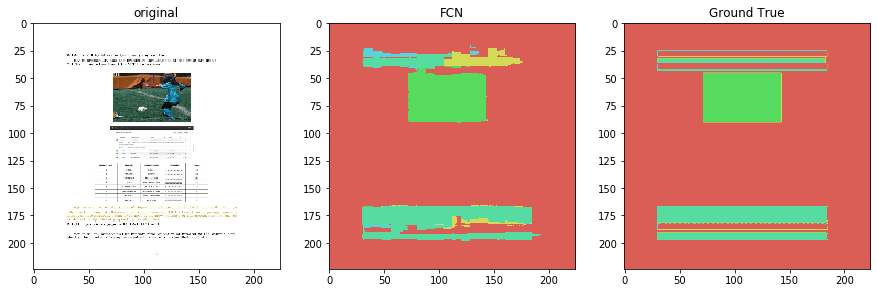

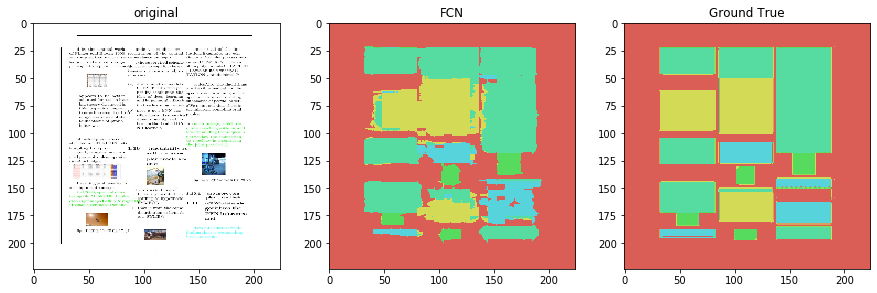

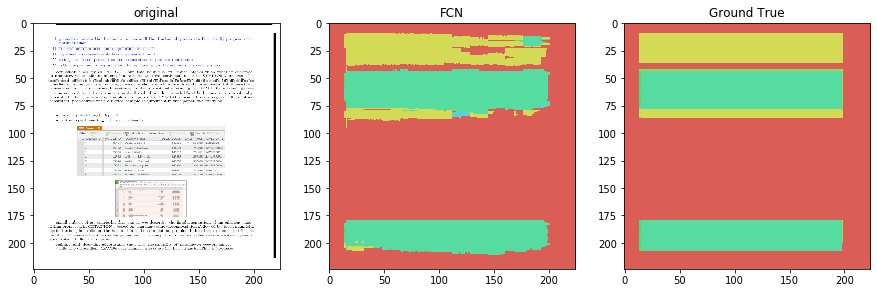

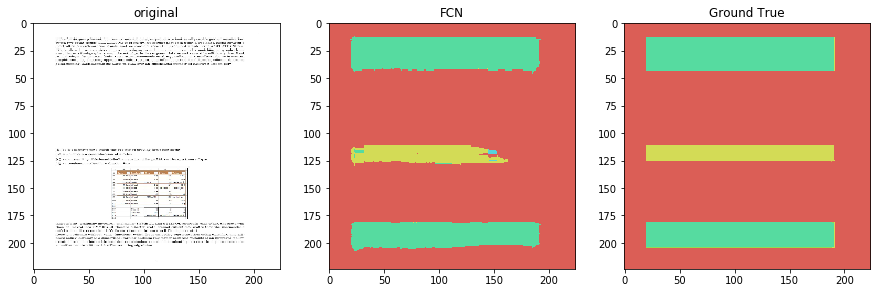

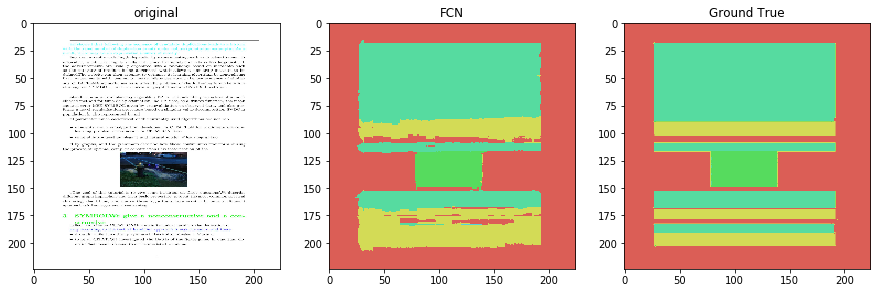

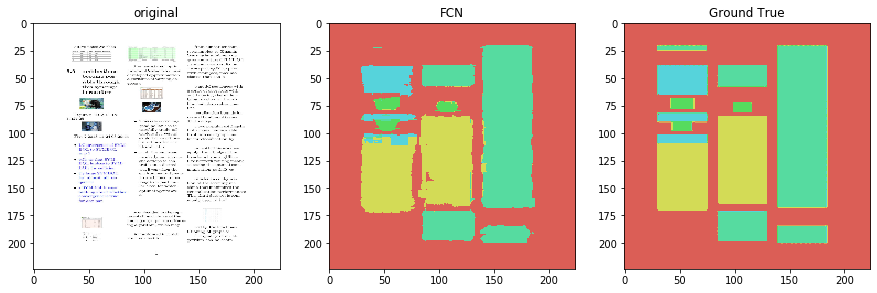

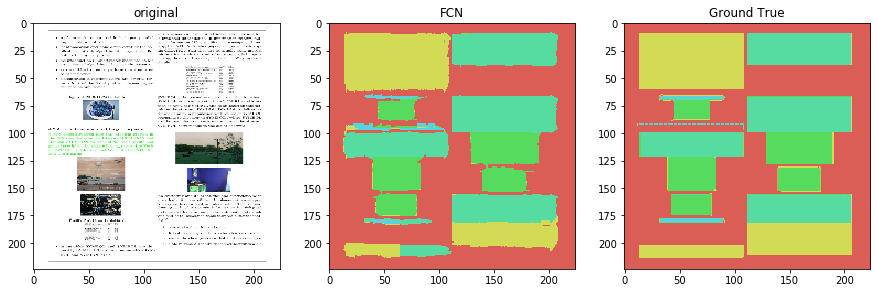

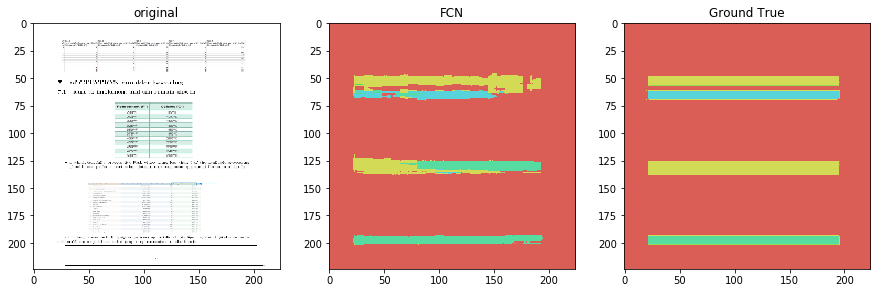

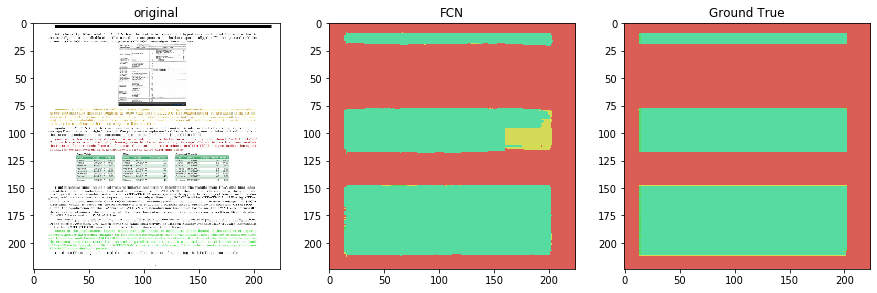

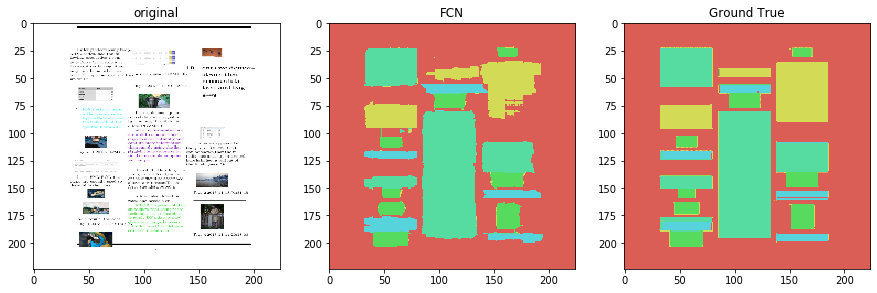

In [12]:
#Visualize the model performance
shape = (224,224)
n_classes= 9

for i in range(10,20):
    img = X_var[i]
    segpred = y_predi[i]
    seg = y_vari[i]

    fig = plt.figure(figsize=(15,5))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(design_colormap(segpred,n_classes))
    ax.set_title("FCN")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(design_colormap(seg,n_classes))
    ax.set_title("Ground True")
    plt.show()

In [13]:
model.save("VGG_FCN.h5")